In [89]:
import os
import shutil

# 定義路徑
base_dir = r'C:\coding\Professer Proj\Comfy\newMyComfy\myComfyUI\output\lab\hspace'
photo_dir = os.path.join(base_dir, 'photo')
original_dir = os.path.join(photo_dir, 'original')
addnoise_dir = os.path.join(photo_dir, 'addnoise')

# 建立資料夾
os.makedirs(original_dir, exist_ok=True)
os.makedirs(addnoise_dir, exist_ok=True)

# 處理檔案
for i in range(1, 55):
    file_name = f'{i}.pkl'
    file_path = os.path.join(base_dir, file_name)
    
    if i % 3 == 0:
        # 刪除檔案
        if os.path.exists(file_path):
            os.remove(file_path)
    elif i % 3 == 1:
        # 移動到 original 資料夾
        shutil.move(file_path, os.path.join(original_dir, file_name))
    elif i % 3 == 2:
        # 移動到 addnoise 資料夾
        shutil.move(file_path, os.path.join(addnoise_dir, file_name))

In [90]:
import os
import shutil

# 定義路徑
base_dir = r'C:\coding\Professer Proj\Comfy\newMyComfy\myComfyUI\output\latents'
photo_dir = os.path.join(base_dir, 'photo')
original_dir = os.path.join(photo_dir, 'original')
addnoise_dir = os.path.join(photo_dir, 'addnoise')

# 建立資料夾
os.makedirs(original_dir, exist_ok=True)
os.makedirs(addnoise_dir, exist_ok=True)

# 處理檔案
for file_name in os.listdir(base_dir):
    file_path = os.path.join(base_dir, file_name)
    
    if 'original' in file_name:
        shutil.move(file_path, os.path.join(original_dir, file_name))
    elif 'addnoise' in file_name:
        shutil.move(file_path, os.path.join(addnoise_dir, file_name))

# START

In [91]:
# subjects = ["SDbuilding", "SDsportcar", "SDsportcar2", "SDtree", "DALLEFish", "DALLEForest", "DALLECar","DALLECar2","DALLETree","DALLEBuilding", "uglycat", "uglycar", "uglycar2","uglybuilding","uglytree","photo_band", "photo_food"]
subjects = ["SDbuilding", "SDsportcar", "SDsportcar2", "SDtree",  "DALLECar","DALLECar2","DALLETree","DALLEBuilding", "uglycar", "uglycar2","uglybuilding","uglytree",]
data_types = ["original", "addnoise"]

# Rename file

In [92]:
import os
import glob

def rename_files_in_directory(directory):
    # Step 1: Add "QQQ" in front of each filename to prevent conflicts
    for root, _, files in os.walk(directory):
        for filename in files:
            old_path = os.path.join(root, filename)
            new_path = os.path.join(root, "QQQ" + filename)
            os.rename(old_path, new_path)
    
    # Step 2: Rename files sequentially starting from 1
    for root, _, files in os.walk(directory):
        files = sorted(files)  # Sort files to maintain original order
        for i, filename in enumerate(files, start=1):
            old_path = os.path.join(root, filename)
            file_extension = os.path.splitext(filename)[1]
            new_filename = f"{i}{file_extension}"
            new_path = os.path.join(root, new_filename)
            os.rename(old_path, new_path)

# Define the root directory
root_directory = 'hspace'

# Traverse through each subdirectory in the root directory
for subdir in glob.glob(os.path.join(root_directory, '**'), recursive=True):
    if os.path.isdir(subdir):
        rename_files_in_directory(subdir)

# Repeat for the 'latent' directory
root_directory = 'latent'
for subdir in glob.glob(os.path.join(root_directory, '**'), recursive=True):
    if os.path.isdir(subdir):
        rename_files_in_directory(subdir)

# 讀取檔案


In [94]:
import os
import glob
import pickle
import torch
import safetensors.torch

def load_hspace_file(filepath):
    """讀取 .pkl 檔案，並將 numpy.ndarray 轉換為 torch tensor"""
    with open(filepath, 'rb') as f:
        arr = pickle.load(f)
    return torch.from_numpy(arr)

def load_latent_file(filepath):
    """利用 safetensors.torch 讀取 .latent 檔案，並取出 'latent_tensor'"""
    sd = safetensors.torch.load_file(filepath)
    return sd['latent_tensor']

def load_all_data(base_dirs=["hspace", "latent"], subjects=subjects, types=data_types, num_files=18):
    data = {}
    for subject in subjects:
        data[subject] = {"hspace": {}, "latent": {}}
        for base in base_dirs:
            # 設定副檔名依據 base
            ext = "pkl" if base == "hspace" else "latent"
            for t in types:
                # 組成路徑 pattern，例如 "hspace/building/original/*.pkl"
                pattern = os.path.join(base, subject, t, f"*.{ext}")
                file_list = sorted(glob.glob(pattern))
                # 若希望依照數字排序，且檔名為 1 ~ 18，可考慮使用檔名排序
                # 若 file_list 長度不等於 num_files，可自行檢查或跳過錯誤
                tensor_list = []
                for filepath in file_list:
                    if base == "hspace":
                        tensor = load_hspace_file(filepath)
                    else:
                        tensor = load_latent_file(filepath)
                    tensor_list.append(tensor)
                data[subject][base][t] = tensor_list
    return data

# 執行資料載入
data_dict = load_all_data()

# 檢查其中一個 subject 的資料形狀，例如 building 的 hspace original 第一筆
print("building hspace original[0] shape:", data_dict["SDbuilding"]["hspace"]["original"][0].shape)
print("building latent original[0] shape:", data_dict["SDbuilding"]["latent"]["original"][0].shape)

# 之後即可將 data_dict 的 tensor list 轉換為 tensor 後做 MSE 與 Fréchet Distance 計算
# 例如：將 building 的 hspace original 列表轉成 tensor
building_hspace_original = torch.stack(data_dict["SDbuilding"]["hspace"]["original"])
print("Stacked building hspace original shape:", building_hspace_original.shape)


building hspace original[0] shape: torch.Size([2, 1280, 8, 8])
building latent original[0] shape: torch.Size([1, 4, 64, 64])
Stacked building hspace original shape: torch.Size([18, 2, 1280, 8, 8])


In [96]:
print(len(data_dict["SDbuilding"]["hspace"]["original"]))

18


## 轉換成 Numpy

In [97]:
import numpy as np

def convert_to_numpy(data_dict):
    for subject in data_dict:
        for domain in data_dict[subject]:
            for data_type in data_dict[subject][domain]:
                data_dict[subject][domain][data_type] = [tensor.numpy() for tensor in data_dict[subject][domain][data_type]]

# Convert all tensors in data_dict to numpy arrays
convert_to_numpy(data_dict)

# Verify the conversion
print(type(data_dict["SDbuilding"]["hspace"]["original"][0]))  # Should print <class 'numpy.ndarray'>
print(data_dict["SDbuilding"]["hspace"]["original"][0].shape)  # Should print the shape of the numpy array

<class 'numpy.ndarray'>
(2, 1280, 8, 8)


In [98]:
import numpy as np

def euclidean(p1, p2):
    return np.linalg.norm(np.array(p1) - np.array(p2))

def frechet_recursive(ca, P, Q, i, j):
    if ca[i, j] > -1:
        return ca[i, j]
    elif i == 0 and j == 0:
        ca[i, j] = euclidean(P[0], Q[0])
    elif i > 0 and j == 0:
        ca[i, j] = max(frechet_recursive(ca, P, Q, i-1, 0), euclidean(P[i], Q[0]))
    elif i == 0 and j > 0:
        ca[i, j] = max(frechet_recursive(ca, P, Q, 0, j-1), euclidean(P[0], Q[j]))
    elif i > 0 and j > 0:
        ca[i, j] = max(min(frechet_recursive(ca, P, Q, i-1, j),
                           frechet_recursive(ca, P, Q, i-1, j-1),
                           frechet_recursive(ca, P, Q, i, j-1)),
                       euclidean(P[i], Q[j]))
    else:
        ca[i, j] = float('inf')
    return ca[i, j]

def frechet_distance(P, Q):
    ca = np.ones((len(P), len(Q))) * -1
    return frechet_recursive(ca, P, Q, len(P)-1, len(Q)-1)




In [99]:
domains = ["hspace", "latent"]
# all_subjects = ["building", "sportcar", "sportcar2", "tree", "uglycat", "DALLEFish", "DALLEForest", "photo_band", "photo_food"]
all_subjects = subjects
for domain in domains:
    print(f"in {domain}")
    for subject in all_subjects:
        P = data_dict[subject][domain]["original"]
        Q = data_dict[subject][domain]["addnoise"]
        print(f"{subject} Fréchet Distance: {frechet_distance(P, Q)}")



in hspace
SDbuilding Fréchet Distance: 1579.61669921875
SDsportcar Fréchet Distance: 1598.958251953125
SDsportcar2 Fréchet Distance: 1733.3509521484375
SDtree Fréchet Distance: 1409.613525390625
DALLECar Fréchet Distance: 1206.51611328125
DALLECar2 Fréchet Distance: 1675.8450927734375
DALLETree Fréchet Distance: 1039.4329833984375
DALLEBuilding Fréchet Distance: 1694.5723876953125
uglycar Fréchet Distance: 1462.0396728515625
uglycar2 Fréchet Distance: 986.5678100585938
uglybuilding Fréchet Distance: 965.6221923828125
uglytree Fréchet Distance: 978.6881713867188
in latent
SDbuilding Fréchet Distance: 2199.52978515625
SDsportcar Fréchet Distance: 1568.891357421875
SDsportcar2 Fréchet Distance: 1565.7410888671875
SDtree Fréchet Distance: 1565.435546875
DALLECar Fréchet Distance: 1564.6480712890625
DALLECar2 Fréchet Distance: 1566.2620849609375
DALLETree Fréchet Distance: 1567.08056640625
DALLEBuilding Fréchet Distance: 1566.0364990234375
uglycar Fréchet Distance: 1701.6611328125
uglycar2 

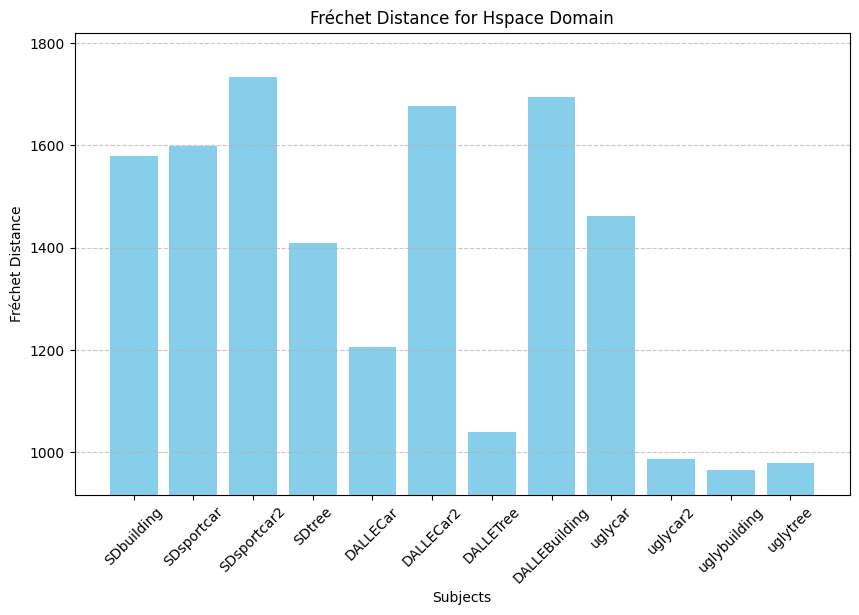

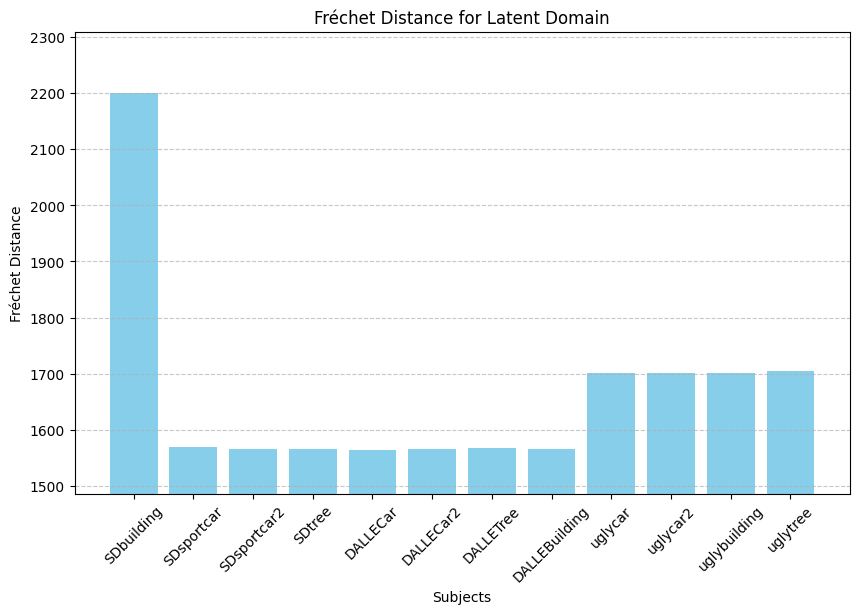

In [100]:
import matplotlib.pyplot as plt

# Initialize a dictionary to store Fréchet distances
fd_results = {domain: {} for domain in domains}

# Calculate Fréchet distances for all subjects in each domain
for domain in domains:
    for subject in all_subjects:
        P = data_dict[subject][domain]["original"]
        Q = data_dict[subject][domain]["addnoise"]
        fd_results[domain][subject] = frechet_distance(P, Q).item()

# Plot the Fréchet distances for each domain
for domain in domains:
    plt.figure(figsize=(10, 6))
    subjects = list(fd_results[domain].keys())
    fd_values = list(fd_results[domain].values())
    plt.bar(subjects, fd_values, color='skyblue')
    plt.xlabel("Subjects")
    plt.ylabel("Fréchet Distance")
    plt.title(f"Fréchet Distance for {domain.capitalize()} Domain")
    plt.xticks(rotation=45)
    plt.ylim(min(fd_values) * 0.95, max(fd_values) * 1.05)  # Adjust y-axis limits
    plt.grid(axis="y", linestyle="--", alpha=0.7)
    plt.show()

In [ ]:
import numpy as np

# 將 fd_values 分成每四個一組，計算平均值
fd_values = [2199.52978515625, 1568.891357421875, 1565.7410888671875, 1565.435546875, 1564.6480712890625, 1566.2620849609375, 1567.08056640625, 1566.0364990234375, 1701.6611328125, 1701.9879150390625, 1700.56787109375, 1705.6126708984375]
fd_values = np.array(fd_values)
fd_means = [fd_values[i:i+4].mean() for i in range(0, len(fd_values), 4)]

print(fd_means)

# 分別計算 MSE

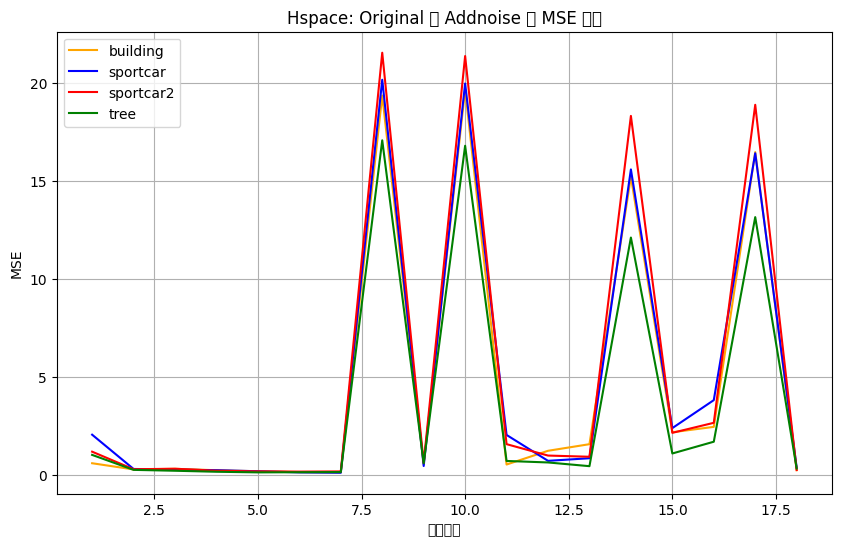

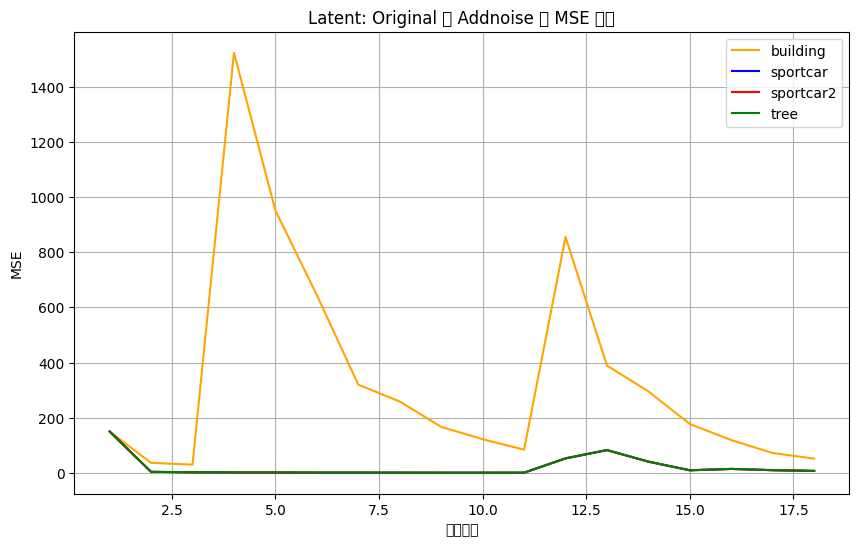

In [ ]:
import matplotlib.pyplot as plt
import torch.nn.functional as F

# 定義各 subject 的線條顏色
colors = {
    "building": "orange",
    "tree": "green",
    "sportcar": "blue",
    "sportcar2": "red"
}

subjects = ["building", "sportcar", "sportcar2", "tree"]

# 計算 original 與 addnoise 的 MSE
# mse_results 結構：{ "hspace": {subject: [mse1, mse2, ...]}, "latent": {subject: [...] } }
mse_results = {"hspace": {}, "latent": {}}

for domain in ["hspace", "latent"]:
    for subject in subjects:
        orig_list = data_dict[subject][domain]["original"]
        noise_list = data_dict[subject][domain]["addnoise"]
        mse_vals = []
        # 假設每個 subject 下檔案數量一致
        for orig, noise in zip(orig_list, noise_list):
            mse_val = F.mse_loss(orig, noise).item()
            mse_vals.append(mse_val)
        mse_results[domain][subject] = mse_vals

# 畫出 hspace 的 MSE 差異圖
plt.figure(figsize=(10, 6))
for subject in subjects:
    plt.plot(
        range(1, len(mse_results["hspace"][subject]) + 1),
        mse_results["hspace"][subject],
        color=colors[subject],
        label=subject
    )
plt.xlabel("time step")
plt.ylabel("MSE")
plt.title("Hspace: Original vs Addnoise MSE")
plt.legend()
plt.grid(True)
plt.show()

# 畫出 latent 的 MSE 差異圖
plt.figure(figsize=(10, 6))
for subject in subjects:
    plt.plot(
        range(1, len(mse_results["latent"][subject]) + 1),
        mse_results["latent"][subject],
        color=colors[subject],
        label=subject
    )
plt.xlabel("time step")
plt.ylabel("MSE")
plt.title("Latent: Original vs Addnoise MSE")
plt.legend()
plt.grid(True)
plt.show()


c:\Users\9373k\miniconda3\envs\comfy\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 25976 (\N{CJK UNIFIED IDEOGRAPH-6578}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\9373k\miniconda3\envs\comfy\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 25818 (\N{CJK UNIFIED IDEOGRAPH-64DA}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


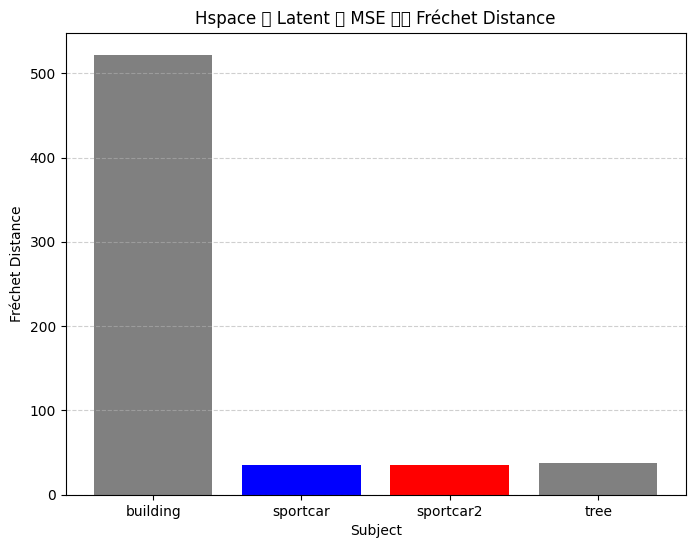

In [19]:
import torch
import matplotlib.pyplot as plt

# 由於是 1 維數據，先定義計算共變異數與矩陣平方根的輔助函式
def compute_cov_tensor(X):
    n = X.size(0)
    mean = X.mean(dim=0, keepdim=True)
    X_centered = X - mean
    cov = X_centered.t() @ X_centered / (n - 1)
    return cov

def sqrtm(matrix):
    # 使用 eigh 適用於對稱正定矩陣，返回的 eigenvalues 為實數
    eigvals, eigvecs = torch.linalg.eigh(matrix)
    sqrt_eigvals = torch.sqrt(eigvals)
    # 重組矩陣平方根
    sqrt_matrix = eigvecs @ torch.diag(sqrt_eigvals) @ eigvecs.t()
    return sqrt_matrix


def frechet_distance_tensor(X, Y):
    """
    計算兩個分布 (X 與 Y 均為 shape (N, d)) 的 Fréchet distance。
    在此範例中 X 與 Y 為 1 維的資料（shape (N, 1)）。
    """
    mu_X = X.mean(dim=0)
    mu_Y = Y.mean(dim=0)
    sigma_X = compute_cov_tensor(X)
    sigma_Y = compute_cov_tensor(Y)
    diff = mu_X - mu_Y
    diff_norm = torch.dot(diff, diff)
    covmean = sqrtm(sigma_X @ sigma_Y)
    trace_covmean = torch.trace(covmean)
    fid = diff_norm + torch.trace(sigma_X) + torch.trace(sigma_Y) - 2 * trace_covmean
    return torch.sqrt(fid)

subjects = ["building", "sportcar", "sportcar2", "tree"]
colors = {
    "building": "gray",
    "tree": "gray",
    "sportcar": "blue",
    "sportcar2": "red"
}

# 直接在輸入時將 mse_results 的數據轉型為 tensor（指定 dtype 為 float32），並調整為 (N, 1) 的形狀
fd_values = {}
for subject in subjects:
    hspace_tensor = torch.tensor(mse_results["hspace"][subject], dtype=torch.float32).unsqueeze(1)
    latent_tensor = torch.tensor(mse_results["latent"][subject], dtype=torch.float32).unsqueeze(1)
    fd = frechet_distance_tensor(hspace_tensor, latent_tensor)
    fd_values[subject] = fd.item()

# 繪製長條圖
plt.figure(figsize=(8, 6))
plt.bar(fd_values.keys(), fd_values.values(), color=[colors[sub] for sub in fd_values.keys()])
plt.xlabel("Subject")
plt.ylabel("Fréchet Distance")
plt.title("Hspace 與 Latent 之 MSE 數據 Fréchet Distance")
plt.grid(axis="y", linestyle="--", alpha=0.6)
plt.show()


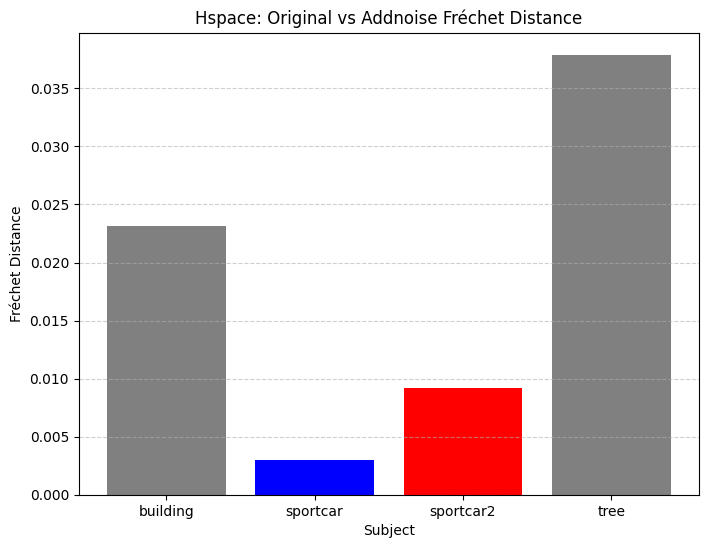

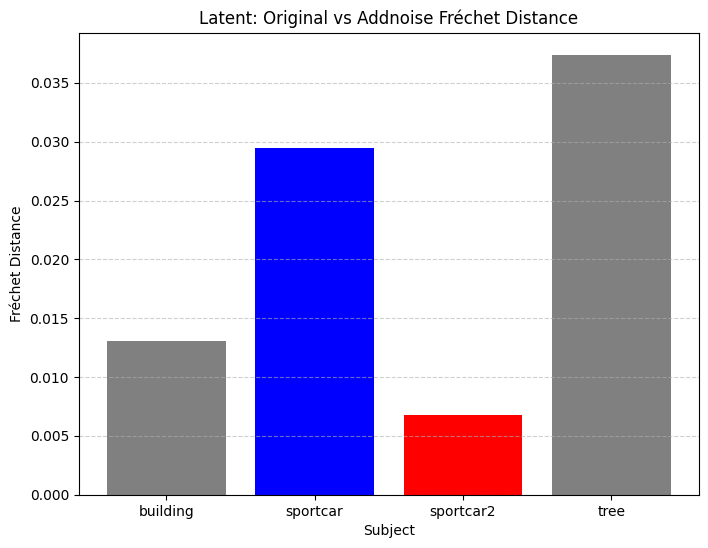

In [20]:
import torch
import matplotlib.pyplot as plt
import random

# ---------------------------
# 輔助函式：計算共變異數與矩陣平方根
# ---------------------------
def compute_cov_tensor(X):
    """X shape: (N, d)"""
    n = X.size(0)
    mean = X.mean(dim=0, keepdim=True)
    X_centered = X - mean
    cov = X_centered.t() @ X_centered / (n - 1)
    return cov

def sqrtm(matrix):
    """
    針對對稱正定矩陣使用 torch.linalg.eigh，
    可確保所有運算均為實數，避免 complex 型別錯誤。
    """
    eigvals, eigvecs = torch.linalg.eigh(matrix)
    sqrt_eigvals = torch.sqrt(eigvals)
    sqrt_matrix = eigvecs @ torch.diag(sqrt_eigvals) @ eigvecs.t()
    return sqrt_matrix

def frechet_distance_tensor(X, Y):
    """
    計算兩個分布 (X 與 Y 均為 shape (N, d)) 的 Fréchet Distance。
    這裡 X 與 Y 為 1 維資料（形狀 (N, 1)），分別來自 "original" 與 "addnoise" 的 MSE 數據。
    """
    mu_X = X.mean(dim=0)
    mu_Y = Y.mean(dim=0)
    sigma_X = compute_cov_tensor(X)
    sigma_Y = compute_cov_tensor(Y)
    diff = mu_X - mu_Y
    diff_norm = torch.dot(diff, diff)
    covmean = sqrtm(sigma_X @ sigma_Y)
    trace_covmean = torch.trace(covmean)
    fid = diff_norm + torch.trace(sigma_X) + torch.trace(sigma_Y) - 2 * trace_covmean
    return torch.sqrt(fid)

# ---------------------------
# 模擬 mse_results 數據（測試用）
# 結構：
# mse_results = {
#    "hspace": { subject: {"original": [18 個數值], "addnoise": [18 個數值]} , ... },
#    "latent": { subject: {"original": [18 個數值], "addnoise": [18 個數值]} , ... }
# }
# ---------------------------
subjects = ["building", "sportcar", "sportcar2", "tree"]
domains = ["hspace", "latent"]
mse_results = {domain: {} for domain in domains}
random.seed(42)
for domain in domains:
    for subject in subjects:
        # 模擬原始數據：18 個隨機浮點數
        mse_orig = [random.uniform(0, 1) for _ in range(18)]
        # 模擬加雜訊後數據：在原始數值上加上小幅隨機變動
        mse_add = [m + random.uniform(-0.1, 0.1) for m in mse_orig]
        mse_results[domain][subject] = {"original": mse_orig, "addnoise": mse_add}

# ---------------------------
# 定義顏色
# ---------------------------
colors = {
    "building": "gray",
    "tree": "gray",
    "sportcar": "blue",
    "sportcar2": "red"
}

# ---------------------------
# 計算 Fréchet Distance
# 分別針對 hspace 與 latent，各 subject 以 "original" 與 "addnoise" 的 MSE 數據計算 FD
# ---------------------------
fd_values = {domain: {} for domain in domains}
for domain in domains:
    for subject in subjects:
        # 直接轉型並調整形狀為 (N, 1)
        orig_tensor = torch.tensor(mse_results[domain][subject]["original"], dtype=torch.float32).unsqueeze(1)
        add_tensor = torch.tensor(mse_results[domain][subject]["addnoise"], dtype=torch.float32).unsqueeze(1)
        fd = frechet_distance_tensor(orig_tensor, add_tensor)
        fd_values[domain][subject] = fd.item()

# ---------------------------
# 畫出 hspace 與 latent 的 Fréchet Distance 長條圖
# ---------------------------
# hspace 長條圖
plt.figure(figsize=(8, 6))
plt.bar(fd_values["hspace"].keys(), fd_values["hspace"].values(),
        color=[colors[sub] for sub in fd_values["hspace"].keys()])
plt.xlabel("Subject")
plt.ylabel("Fréchet Distance")
plt.title("Hspace: Original vs Addnoise Fréchet Distance")
plt.grid(axis="y", linestyle="--", alpha=0.6)
plt.show()

# latent 長條圖
plt.figure(figsize=(8, 6))
plt.bar(fd_values["latent"].keys(), fd_values["latent"].values(),
        color=[colors[sub] for sub in fd_values["latent"].keys()])
plt.xlabel("Subject")
plt.ylabel("Fréchet Distance")
plt.title("Latent: Original vs Addnoise Fréchet Distance")
plt.grid(axis="y", linestyle="--", alpha=0.6)
plt.show()


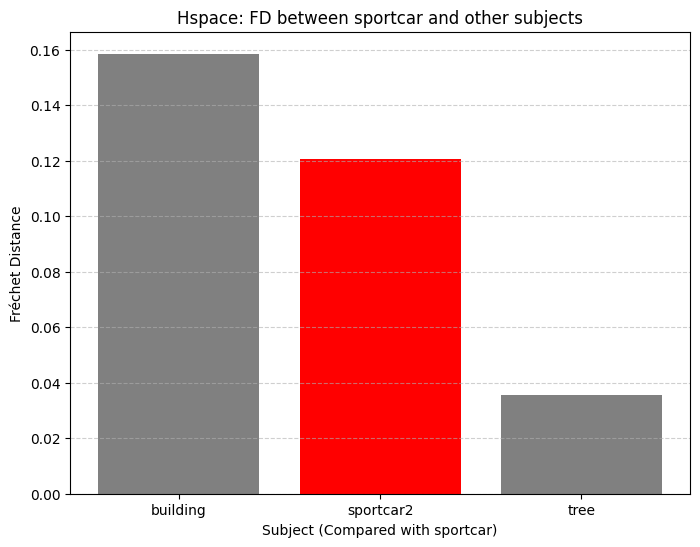

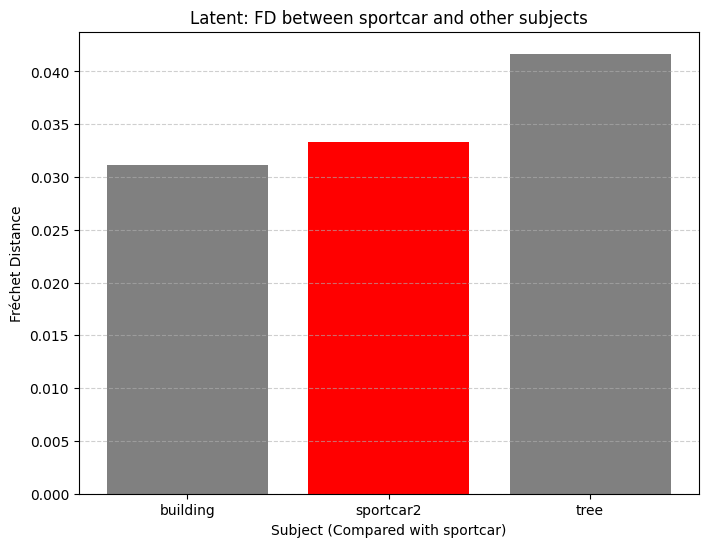

In [21]:
import torch
import matplotlib.pyplot as plt
import random

# ---------------------------
# 輔助函式：計算共變異數與矩陣平方根
# ---------------------------
def compute_cov_tensor(X):
    """計算 X (shape: (N, d)) 的共變異數矩陣"""
    n = X.size(0)
    mean = X.mean(dim=0, keepdim=True)
    X_centered = X - mean
    cov = X_centered.t() @ X_centered / (n - 1)
    return cov

def sqrtm(matrix):
    """
    使用 torch.linalg.eigh 計算對稱正定矩陣的平方根，
    避免 complex 型別混用問題
    """
    eigvals, eigvecs = torch.linalg.eigh(matrix)
    sqrt_eigvals = torch.sqrt(eigvals)
    sqrt_matrix = eigvecs @ torch.diag(sqrt_eigvals) @ eigvecs.t()
    return sqrt_matrix

def frechet_distance_tensor(X, Y):
    """
    計算兩個分布（X 與 Y 皆為 shape (N, d)）的 Fréchet Distance。
    此處 X 與 Y 為 1 維數據（shape: (N, 1)）。
    """
    mu_X = X.mean(dim=0)
    mu_Y = Y.mean(dim=0)
    sigma_X = compute_cov_tensor(X)
    sigma_Y = compute_cov_tensor(Y)
    diff = mu_X - mu_Y
    diff_norm = torch.dot(diff, diff)
    covmean = sqrtm(sigma_X @ sigma_Y)
    trace_covmean = torch.trace(covmean)
    fid = diff_norm + torch.trace(sigma_X) + torch.trace(sigma_Y) - 2 * trace_covmean
    return torch.sqrt(fid)

# ---------------------------
# 模擬 mse_results 數據（若已有數據可省略此段）
# mse_results 結構：
# mse_results = {
#    "hspace": { subject: {"original": [18 個數值]} , ... },
#    "latent": { subject: {"original": [18 個數值]} , ... }
# }
# ---------------------------
subjects = ["building", "sportcar", "sportcar2", "tree"]
domains = ["hspace", "latent"]
mse_results = {domain: {} for domain in domains}
random.seed(42)
for domain in domains:
    for subject in subjects:
        mse_orig = [random.uniform(0, 1) for _ in range(18)]
        mse_results[domain][subject] = {"original": mse_orig}

# ---------------------------
# 以 sportcar 為參考，計算 FD 比較
# ---------------------------
ref_subject = "sportcar"
comp_subjects = [s for s in subjects if s != ref_subject]

fd_comp = {domain: {} for domain in domains}
for domain in domains:
    # 將參考數據轉換成 tensor (shape: (18, 1))
    ref_tensor = torch.tensor(mse_results[domain][ref_subject]["original"], dtype=torch.float32).unsqueeze(1)
    for subject in comp_subjects:
        other_tensor = torch.tensor(mse_results[domain][subject]["original"], dtype=torch.float32).unsqueeze(1)
        fd = frechet_distance_tensor(ref_tensor, other_tensor)
        fd_comp[domain][subject] = fd.item()

# ---------------------------
# 定義各 subject 顏色（依照題目設定：building 與 tree 為灰色，sportcar2 為紅色）
# ---------------------------
# 注意：此處 sportcar 為參考，不列於長條圖中
color_map = {
    "building": "gray",
    "tree": "gray",
    "sportcar2": "red"
}

# ---------------------------
# 畫出 hspace 與 latent 兩張長條圖
# ---------------------------
for domain in domains:
    plt.figure(figsize=(8, 6))
    subjects_to_plot = list(fd_comp[domain].keys())
    colors = [color_map[sub] for sub in subjects_to_plot]
    plt.bar(subjects_to_plot, [fd_comp[domain][s] for s in subjects_to_plot], color=colors)
    plt.xlabel("Subject (Compared with sportcar)")
    plt.ylabel("Fréchet Distance")
    plt.title(f"{domain.capitalize()}: FD between sportcar and other subjects")
    plt.grid(axis="y", linestyle="--", alpha=0.6)
    plt.show()


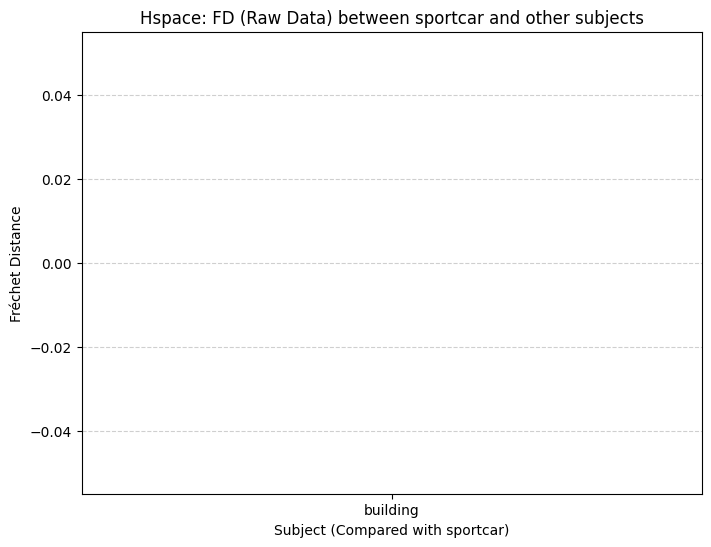

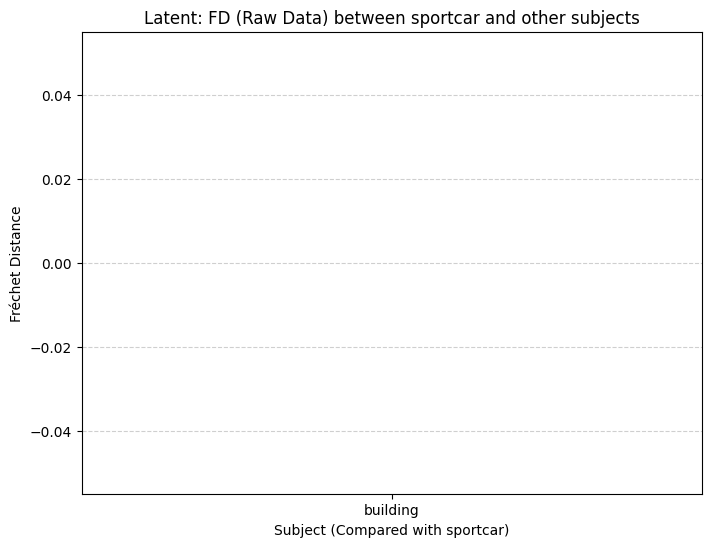

In [22]:
import torch
import matplotlib.pyplot as plt

# ---------------------------
# 輔助函式：計算共變異數與矩陣平方根
# ---------------------------
def compute_cov_tensor(X):
    """
    輸入 X (shape: (N, d))，回傳共變異數矩陣 (d, d)
    """
    n = X.size(0)
    mean = X.mean(dim=0, keepdim=True)
    X_centered = X - mean
    cov = X_centered.t() @ X_centered / (n - 1)
    return cov

def sqrtm(matrix):
    """
    使用 torch.linalg.eigh 針對對稱正定矩陣計算矩陣平方根
    """
    eigvals, eigvecs = torch.linalg.eigh(matrix)
    sqrt_eigvals = torch.sqrt(eigvals)
    sqrt_matrix = eigvecs @ torch.diag(sqrt_eigvals) @ eigvecs.t()
    return sqrt_matrix

def frechet_distance_tensor(X, Y):
    """
    計算兩個分布 (X 與 Y 皆為 shape (N, d)) 的 Fréchet Distance
    FD = sqrt(||mu_X - mu_Y||^2 + trace(sigma_X) + trace(sigma_Y) - 2 trace(sqrtm(sigma_X sigma_Y)))
    """
    mu_X = X.mean(dim=0)
    mu_Y = Y.mean(dim=0)
    sigma_X = compute_cov_tensor(X)
    sigma_Y = compute_cov_tensor(Y)
    diff = mu_X - mu_Y
    diff_norm = torch.dot(diff, diff)
    covmean = sqrtm(sigma_X @ sigma_Y)
    trace_covmean = torch.trace(covmean)
    fid = diff_norm + torch.trace(sigma_X) + torch.trace(sigma_Y) - 2 * trace_covmean
    return torch.sqrt(fid)

# ---------------------------
# 模擬 raw data 數據（data_dict）
# 若已有 data_dict，請直接使用你的原始資料
# 結構：
# data_dict = {
#    subject: {
#         domain: {
#             "original": [tensor1, tensor2, ...]  (共 18 筆)
#         }
#    },
#    ...
# }
# ---------------------------
import random
subjects = ["building", "sportcar", "sportcar2", "tree"]
domains = ["hspace", "latent"]
data_dict = {}

# 假設每筆 raw data 為一個 shape (10,) 的 tensor（實際上依你的資料而定）
for subject in subjects:
    data_dict[subject] = {}
    for domain in domains:
        # 模擬 18 筆資料
        data_dict[subject][domain] = {
            "original": [torch.randn(10) for _ in range(18)]
        }

# ---------------------------
# 以 sportcar 為參考，計算 FD 比較（直接使用 raw data）
# ---------------------------
fd_comp = {domain: {} for domain in domains}
ref_subject = "sportcar"

for domain in domains:
    # 將 sportcar 的原始資料整合成一個 tensor (shape: (18, d))
    ref_data = torch.stack([t.flatten() for t in data_dict[ref_subject][domain]["original"]])
    for subject in subjects:
        if subject == ref_subject:
            continue
        # 取得其他 subject 的資料，flatten 確保每筆資料都是 1 維向量
        other_data = torch.stack([t.flatten() for t in data_dict[subject][domain]["original"]])
        fd = frechet_distance_tensor(ref_data, other_data)
        fd_comp[domain][subject] = fd.item()

# ---------------------------
# 定義顏色設定：building 與 tree 為灰色，sportcar2 為紅色
# ---------------------------
color_map = {
    "building": "gray",
    "tree": "gray",
    "sportcar2": "red"
}

# ---------------------------
# 畫出 hspace 與 latent 的 Fréchet Distance 長條圖
# ---------------------------
for domain in domains:
    plt.figure(figsize=(8, 6))
    subjects_to_plot = list(fd_comp[domain].keys())
    colors = [color_map[sub] for sub in subjects_to_plot]
    fd_values = [fd_comp[domain][sub] for sub in subjects_to_plot]
    plt.bar(subjects_to_plot, fd_values, color=colors)
    plt.xlabel("Subject (Compared with sportcar)")
    plt.ylabel("Fréchet Distance")
    plt.title(f"{domain.capitalize()}: FD (Raw Data) between sportcar and other subjects")
    plt.grid(axis="y", linestyle="--", alpha=0.6)
    plt.show()


In [ ]:
import torch
import matplotlib.pyplot as plt

# 定義共變異數計算函式
def compute_cov(x):
    n = x.size(0)
    mean = x.mean(dim=0, keepdim=True)
    x_centered = x - mean
    cov = x_centered.t() @ x_centered / (n - 1)
    return cov

# 計算對稱正定矩陣的平方根
def sqrtm(matrix):
    # 對稱正定矩陣使用 torch.linalg.eigh 獲得實數 eigenvalues 與 eigenvectors
    eigvals, eigvecs = torch.linalg.eigh(matrix)
    # 避免因數值誤差產生負 eigenvalue，先 clamp 再取平方根
    sqrt_eigvals = torch.sqrt(torch.clamp(eigvals, min=0))
    # 由於 eigenvectors 為正交矩陣，因此使用 eigvecs 與其轉置
    sqrt_matrix = eigvecs @ torch.diag(sqrt_eigvals) @ eigvecs.t()
    return sqrt_matrix


# 計算 Fréchet Distance 的函式，輸入為 tensor 串列
def frechet_distance(tensor_list1, tensor_list2):
    X = torch.stack(tensor_list1)  # shape: (N, d)
    Y = torch.stack(tensor_list2)
    
    mu_X = X.mean(dim=0)
    mu_Y = Y.mean(dim=0)
    sigma_X = compute_cov(X)
    sigma_Y = compute_cov(Y)
    
    diff = mu_X - mu_Y
    diff_norm = torch.dot(diff, diff)
    
    covmean = sqrtm(sigma_X @ sigma_Y)
    trace_covmean = torch.trace(covmean)
    
    fid = diff_norm + torch.trace(sigma_X) + torch.trace(sigma_Y) - 2 * trace_covmean
    return torch.sqrt(fid)

# 定義各分類與顏色對應（building 與 tree 為灰色，sportcar 為藍色，sportcar2 為紅色）
subjects = ["building", "sportcar", "sportcar2", "tree"]
colors = {"building": "gray", "sportcar": "blue", "sportcar2": "red", "tree": "gray"}

# 計算每個 subject (使用 original 資料) 與 sportcar 的 Fréchet Distance
# 分別對 hspace 與 latent 計算
fd_results = {"hspace": {}, "latent": {}}
for domain in ["hspace", "latent"]:
    for subject in subjects:
        # 使用 data_dict 中對應的 "original" tensor list
        # 比較 subject 與 sportcar 的原始數據
        fd = frechet_distance(data_dict[subject][domain]["original"],
                              data_dict["sportcar"][domain]["original"])
        fd_results[domain][subject] = fd.item()

# 繪製 hspace 的 Fréchet Distance 長條圖
plt.figure(figsize=(8, 6))
hspace_bars = [fd_results["hspace"][subj] for subj in subjects]
plt.bar(subjects, hspace_bars, color=[colors[subj] for subj in subjects])
plt.xlabel("分類")
plt.ylabel("Fréchet Distance")
plt.title("Hspace: 各分類與 sportcar 原始數據的 Fréchet Distance")
plt.show()

# 繪製 latent 的 Fréchet Distance 長條圖
plt.figure(figsize=(8, 6))
latent_bars = [fd_results["latent"][subj] for subj in subjects]
plt.bar(subjects, latent_bars, color=[colors[subj] for subj in subjects])
plt.xlabel("分類")
plt.ylabel("Fréchet Distance")
plt.title("Latent: 各分類與 sportcar 原始數據的 Fréchet Distance")
plt.show()


RuntimeError: expected m1 and m2 to have the same dtype, but got: struct c10::complex<float> != float